In [1]:
import math, random, pickle, os, copy, itertools, sys
import torch, logging, scipy.io
import numpy as np
import pandas as pd
from numpy import random
from datetime import datetime
import matplotlib.pyplot as plt
from collections.abc import Iterable

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

#from third_party.Synthetic_PV_Profiles import CityPV_UniModal, CityPV_MultiModal
from feature_selection import tune_pacf, rfecv_selection
from samples.PV.data_sim import remove_feature

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


ModuleNotFoundError: No module named 'utils'

In [2]:
exp_name = 'PV_UniModal'
filename_env = os.getcwd() + "/saved_results/" + exp_name + "_env"
file = open(filename_env+'_raw', 'rb')
print(filename_env+'_raw')
env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))

/home/mahrokhg/Cloned_FL/Federated-Hyper-Posterior-Learning/experiments/PV/saved_results/PV_UniModal_env_raw
[INFO] loaded data for 24 clients

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.6, different module_name, different inverter_name, 
sml has  50 train and 140 validation samples
1y has 610 train and 140 validation samples
5y has 3050 train and 140 validation samples
15y has 9150 train and 140 validation samples
number of features =  9


In [3]:
# reconstruct houses
from third_party.Synthetic_PV_Profiles.house_pv import reconstruct_house
scenario_name_recons='15y'
clients_subset = [0]
houses = [None] * env_dict['num_clients']
for client_num in clients_subset:
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


[INFO] reconstructed the 15y scenario.


[RES] observations:
1) H_sun, hourofd_y, irrad_direct, and irrad_diffuse are highly correlated
2) dayofy_y and T2m are highly correlated


/tmp/ipykernel_3596241/1411071617.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=np.bool),


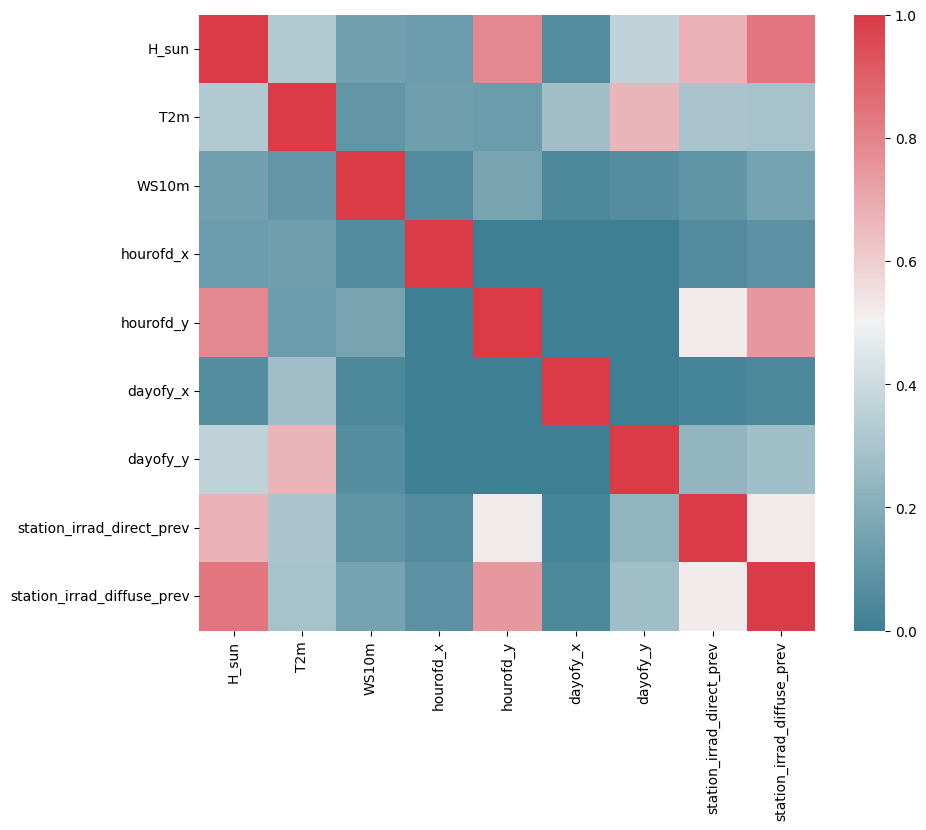

In [4]:
# correlation map between features
import seaborn as sns

non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(10, 8))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=np.bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)

msg = '[RES] observations:'
msg += '\n1) H_sun, hourofd_y, irrad_direct, and irrad_diffuse are highly correlated'
msg += '\n2) dayofy_y and T2m are highly correlated'
print(msg)



In [5]:
# correlation with the power
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
for client_num in clients_subset:
    print('\nClient {:2.0f}'.format(client_num))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
    print(corr)


msg = '\n[RES] observations:'
msg += '\n1) correlation with dayofy_x is very low '
print(msg)


Client  0
H_sun                         0.855523
T2m                           0.250068
WS10m                         0.114451
hourofd_x                     0.120998
hourofd_y                    -0.682327
dayofy_x                      0.042091
dayofy_y                     -0.234152
station_irrad_direct_prev     0.820912
station_irrad_diffuse_prev    0.723646
dtype: float64

[RES] observations:
1) correlation with dayofy_x is very low 


['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'station_irrad_direct_prev']


/tmp/ipykernel_3596241/2037218509.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=np.bool),


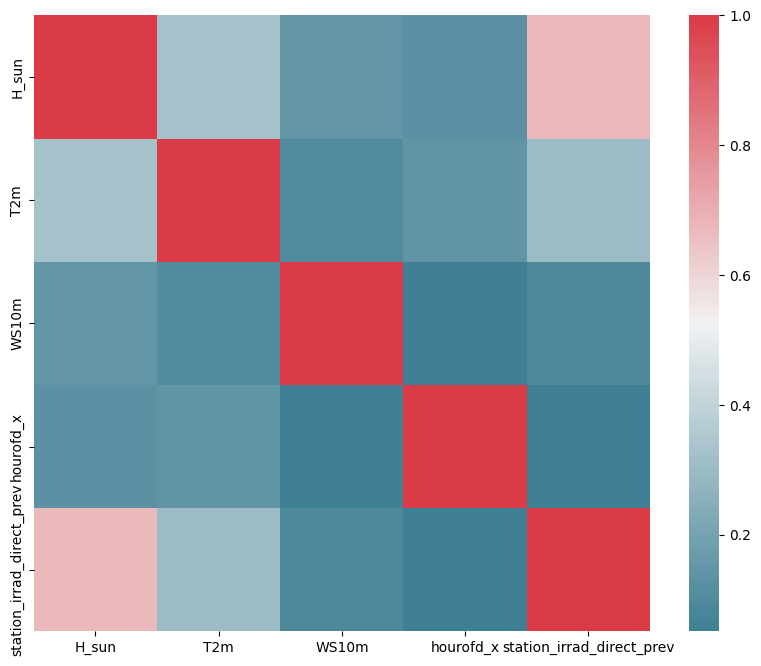

In [6]:
for feature_name in ['hourofd_y', 'dayofy_y', 'dayofy_x', 'station_irrad_diffuse_prev']:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)

print(env_dict['feature_names'])
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(10, 8))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=np.bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)


# Selecting Features with RFECV
using a Ridge model with tuned penalty every time and Adj R2 scorer


In [7]:
from sklearn.feature_selection import RFECV
from utils.search_models import RidgeWrapper
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from third_party.Synthetic_PV_Profiles.house_pv import _augment_lags, remove_constant_cols


def adj_r2_scorer(estimator, X, y):
    y = y.flatten()
    y_pred = estimator.predict(X).flatten()
    R2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1-(1-R2)*(n-1)/(n-p-1)


cv = 2
min_features_to_select = 15

# all lags to try
full_lags = np.arange(1, 
                min(
                    30*24+1, 
                    math.floor(env_dict['train_scenarios'][scenario_name_recons]['clients_data'][0][0].shape[0]/cv)-1))
full_lag_names = ['lag ' + str(x) for x in full_lags]

scenario = env_dict['train_scenarios'][scenario_name_recons]
for client_num, house in enumerate([houses[0]]):

    # augment lags
    house.data_power = _augment_lags(
                            house.data_power, 
                            lags=full_lags, 
                            step_ahead=1)
    house.feature_names += full_lag_names
    
    # construct regression matrices
    data_tuple = house.construct_regression_matrices(
                            m_train=scenario['m_train'],
                            train_years=scenario['train_years'],
                            exclude_last_year=scenario['exclude_last_year'])

    # remove constant lags
    house.data_power, data_tuple, house.feature_names = remove_constant_cols(
                            data_power=house.data_power, 
                            data_tuple=data_tuple, 
                            feature_names=house.feature_names)
    print('[INFO] searching among {:2.0f} features'.format(len(house.feature_names)))
    
    # fit Ridge regression with Grid search over penalty
    ridge_wrapper = RidgeWrapper(alphas=np.logspace(-6,2,20)) 
    
    # fit RFECV
    X_train, y_train, X_valid, y_valid = data_tuple
    selector = RFECV(
                estimator=ridge_wrapper, step=1, cv=2, 
                scoring=adj_r2_scorer, 
                min_features_to_select=min_features_to_select) 
    selector = selector.fit(X_train, y_train.flatten())
    
    selected_features = [house.feature_names[i] for i, x in enumerate(selector.support_) if x]
    print('[INFO] the following {:2.0f} features were selected:'.format(len(selected_features)))
    print(*selected_features)


[INFO] the following 59 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 204 lag 228 lag 252 lag 276 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589 lag 611 lag 612 lag 613 lag 635 lag 636 lag 637 lag 659 lag 660 lag 661 lag 683 lag 684 lag 685 lag 707 lag 708 lag 709
[INFO] searching among 666 features


/home/mahrokhg/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


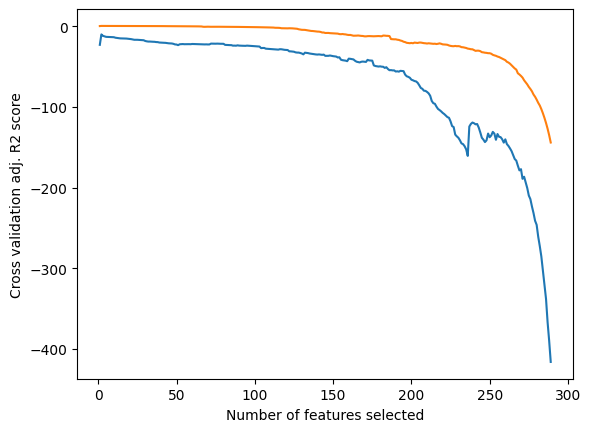


Recurssive Feature Elimination + CV
Optimal number of features: 2
Selected features:
['H_sun', 'station_irrad_direct_prev']


"\n# fit Ridge with selected features\nfor client_num in clients_subset:\n    house = houses[client_num]\n    house.feature_names = feat_rfecv\n    # construct regression matrices\n    data_tuple = house.construct_regression_matrices(\n                            m_train=scenario['m_train'],\n                            train_years=scenario['train_years'],\n                            exclude_last_year=scenario['exclude_last_year'])\n\n    # remove constant lags\n    house.data_power, data_tuple, house.feature_names = remove_constant_cols(\n                            data_power=house.data_power, \n                            data_tuple=data_tuple, \n                            feature_names=house.feature_names)\n\n    # fit Ridge regression with Grid search over penalty\n    best_model, best_res = best_lin_reg(\n        clients_data=[data_tuple], \n        client_num_fix=0, # because only data of 1 client \n        logger=None, \n        criterion='rmse', \n        normalize_data=True

In [9]:
#Force every non-lag feature to be in the RFECV
keep_non_ar = False
if keep_non_ar:
    for i, feature_name in enumerate(house.feature_names):
        if not feature_name.startswith('lag'):
            selector.support_[i] = True

# selected features
feat_rfecv = [house.feature_names[i] for i, x in enumerate(selector.support_) if x]

# Plot number of features VS. cross-validation scores
plot_fig = True
min_features_to_select = 1
if plot_fig:
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation adj. R2 score")
    plt.plot(range(min_features_to_select,
                    len(selector.grid_scores_) + min_features_to_select),
                selector.grid_scores_)
    plt.show()

# display results
verbose = True
if verbose:
    print("\nRecurssive Feature Elimination + CV")
    print("Optimal number of features: %d" % len(feat_rfecv))
    print("Selected features:")
    print(feat_rfecv)

# divide
lag_rfecv = np.array([int(x.replace('lag ','')) for x in feat_rfecv if x.startswith('lag ')])
feat_col_rfecv = [x for x in feat_rfecv if not x.startswith('lag ') and not x=='constant']
'''
# fit Ridge with selected features
for client_num in clients_subset:
    house = houses[client_num]
    house.feature_names = feat_rfecv
    # construct regression matrices
    data_tuple = house.construct_regression_matrices(
                            m_train=scenario['m_train'],
                            train_years=scenario['train_years'],
                            exclude_last_year=scenario['exclude_last_year'])

    # remove constant lags
    house.data_power, data_tuple, house.feature_names = remove_constant_cols(
                            data_power=house.data_power, 
                            data_tuple=data_tuple, 
                            feature_names=house.feature_names)

    # fit Ridge regression with Grid search over penalty
    best_model, best_res = best_lin_reg(
        clients_data=[data_tuple], 
        client_num_fix=0, # because only data of 1 client 
        logger=None, 
        criterion='rmse', 
        normalize_data=True, 
        verbose=True)
        '''

# Feature Selection Based on Several Houses

In [10]:
for client_num in clients_subset:

SyntaxError: incomplete input (1913083271.py, line 1)

In [ ]:
# selecting the lags
for client_num in clients_subset:
    first_in_range, best_num_r, best_num_m, sorted_lags = tune_pacf(
                    house=houses[client_num], max_num_lags=15, max_num_days=30,
                    step_ahead=1, repeats=1, verbose=True)
    print('[RES] lags by first in range: ', *sorted_lags[:first_in_range])
    print('[RES] lags by lowest adj r2: ', *sorted_lags[:best_num_r])
    print(houses[client_num].data_power.shape)


[INFO] sorted lags before removing constant lags during training:  1 20 21 19 22 23 18 47 45 44 46 17 71 69 95 70 68 167 119 93 143 118 48 43 72 94 116 117 24 16 142 92 191 67 166 141 215 144 239 96 190 165 189 213 287 383 120 140 263 214 164 91 192 188 359 431 6 267 339 285 237 479 115 575 262 311 75 478 168 163 236 123 261 212 360 99 260 335 219 284 503 139 312 527 195 30 288 381 407 336 51 308 476 622 453 432 216 286 406 315 670 211 243 600 240 549 380 238 405 551 525 187 309 480 500 477 264 627 696 455 259 548 291 66 388 408 428 435 147 599 42 456 235 171 358 363 694 621 483 648 671 379 620 502 624 387 596 528 652 333 357 430 574 675 526 700 429 716 310 550 572 717 531 669 258 332 411 475 485 458 382 504 524 646 668 404 334 507 90 114 54 356 78 452 437 720 555 573 384 647 651 603 162 175 501 644 378 547 645 199 210 31 126 459 546 295 692 474 186 76 509 245 232 319 27 719 55 426 184 534 234 580 149 598 412 554 701 101 138 695 88 160 223 597 679 472 691 340 112 365 368 307 64 282 522

IndexError: list index out of range

In [ ]:
for client_num in clients_subset:
    lag_rfecv, feat_col_rfecv = rfecv_selection(
                    house=houses[client_num], max_num_days=1, keep_non_ar=True,
                    step_ahead=1, repeats=3, verbose=False, plot_fig=True)
    print('[RES] : ', *lag_rfecv)
    print('[RES] : ', *feat_col_rfecv)



In [ ]:
selected_lags=[1,18, 19, 20, 21, 22, 23, 44, 45, 47]
env_dict.set_lags(selected_lags)
env_dict = env_dict.generate_clients_data()
for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))

save_env = True
if save_env:
    # save env
    file = open(filename_env, 'wb')
    pickle.dump(env_dict, file)
    msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])

# Part 2: Feature Engineering
Weather station direct and diffuse irradiation added to features of all houses
* Irradiation measured at a weather station not at each house => economically feasible
* Effect of including irradiation from weather station
* Do lags add more information?
    ** fit a linear model to 5 years of data, compare accuracies
* Using irradiation at t to predict power at t+1 vs. "predicted" irradiation at t+1 to predict power at t+1
    ** removing the need to another prediction model for the irradiation


### Results:
---------- LINEAR AND RIDGE REGRESSION WITHOUT GP ---------- <br>
sml<br>
with lags mean validation RMSE: 12.91 +/- 12.27<br>
no lags mean validation RMSE: 20.64 +/- 19.00<br>
no irradiation mean validation RMSE: 13.72 +/- 12.96<br>
delayed irradiation mean validation RMSE: 13.02 +/- 12.39<br>
1y<br>
with lags mean validation RMSE: 11.55 +/- 11.19<br>
no lags mean validation RMSE: 20.50 +/- 18.88<br>
no irradiation mean validation RMSE: 12.69 +/- 12.00<br>
delayed irradiation mean validation RMSE: 11.57 +/- 11.22<br>
5y<br>
with lags mean validation RMSE: 11.47 +/- 11.27<br>
no lags mean validation RMSE: 20.43 +/- 18.93<br>
no irradiation mean validation RMSE: 12.28 +/- 11.88<br>
delayed irradiation mean validation RMSE: 11.50 +/- 11.30<br>
15y<br>
with lags mean validation RMSE: 11.48 +/- 11.28<br>
no lags mean validation RMSE: 20.43 +/- 18.93<br>
no irradiation mean validation RMSE: 12.23 +/- 11.70<br>
delayed irradiation mean validation RMSE: 11.50 +/- 11.32<br>

In [ ]:
run_cell = False
if run_cell:
    from utils.search_models import best_lin_reg
    normalize_data=True
    verbose=False

    num_clients=24
    city_names = ['Lausanne']
    env_dict_with_lags = {'city_names':city_names,
                'num_clients': num_clients, 'num_modes': len(city_names),
                'tilt_std': 5, 'az_std':15, 'weather_dev':0.1,
                'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.6,
                'module_name': get_available_modules('sandia')[0:num_clients],
                'inverter_name': get_available_inverters('cec')[0:num_clients],
                'lags':None, 'months':[3,4], 'hours':np.arange(7, 17), 
                'years':np.arange(2014, 2020), # 5 years of data
                'use_station_irrad_direct':True, 'use_station_irrad_diffuse':True,
                'delay_irrad':False, # this env uses predicted irrad
                'train_scenarios':{'sml':{'m_train':50, 'train_years':[2018], 'exclude_last_year':True},
                                '1y':{'m_train':None, 'train_years':[2018], 'exclude_last_year':True},
                                '5y':{'m_train':None, 'train_years':np.arange(2014, 2019), 'exclude_last_year':True},
                                '15y':{'m_train':None, 'train_years':None, 'exclude_last_year':True}}}
    env_dict_with_lags = PVDataset(env_dict_with_lags).generate_clients_data()

    env_dict_no_lags = copy.deepcopy(env_dict_with_lags)
    env_dict_no_irrad = copy.deepcopy(env_dict_with_lags)
    env_dict_delayed = copy.deepcopy(env_dict_with_lags)

    # features to keep 
    inds_to_keep_no_lags, inds_to_keep_no_irrad = [], []
    for ind, feature_name in enumerate(env_dict_with_lags['feature_names']):
        if not feature_name.startswith('lag'):
            inds_to_keep_no_lags.append(ind)
        if not feature_name.startswith('station_irrad'):
            inds_to_keep_no_irrad.append(ind)
    # features to delay for delayed irrads
    cols_to_delay=[]
    for ind, feature_name in enumerate(env_dict_delayed['feature_names']):
        if feature_name.startswith('station_irrad'):
            cols_to_delay.append(ind)

    # only keep the selected features
    for client_num in np.arange(env_dict_with_lags['num_clients']):
        for scenario in env_dict_with_lags['train_scenarios']:
            x_train, y_train, x_valid, y_valid = env_dict_with_lags['train_scenarios'][scenario]['clients_data'][client_num]
            # no lags
            x_train_no_lags = x_train[:, inds_to_keep_no_lags]
            x_valid_no_lags = x_valid[:, inds_to_keep_no_lags]
            env_dict_no_lags['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_no_lags, y_train, x_valid_no_lags, y_valid)
            # no irrad
            x_train_no_irrad = x_train[:, inds_to_keep_no_irrad]
            x_valid_no_irrad = x_valid[:, inds_to_keep_no_irrad]
            env_dict_no_irrad['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_no_irrad, y_train, x_valid_no_irrad, y_valid)
            # delayed irrad
            # NOTE: one less sample
            x_train_dalayed, y_train_dalayed = x_train[1:, :], y_train[1:]
            x_valid_dalayed, y_valid_dalayed = x_valid[1:, :], y_valid[1:]
            x_train_dalayed[:, cols_to_delay] = x_train[:-1, cols_to_delay]
            x_valid_dalayed[:, cols_to_delay] = x_valid[:-1, cols_to_delay]
            env_dict_delayed['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_dalayed, y_train_dalayed, 
                                                            x_valid_dalayed, y_valid_dalayed)


    env_dict_no_lags['feature_names'] = [x for i, x in enumerate(env_dict_no_lags['feature_names']) if i in inds_to_keep_no_lags]
    env_dict_no_irrad['feature_names'] = [x for i, x in enumerate(env_dict_no_irrad['feature_names']) if i in inds_to_keep_no_irrad]



    print('\n---------- LINEAR AND RIDGE REGRESSION WITHOUT GP ----------')
    env_names = ['with lags', 'no lags', 'no irradiation', 'delayed irradiation']
    envs = [env_dict_with_lags, env_dict_no_lags, env_dict_no_irrad, env_dict_delayed]
    for scenario_name in env_dict_with_lags['train_scenarios'].keys():
        print(scenario_name)
        for env_tmp, env_name in zip(envs, env_names):
            # Linear regression without GP
            valid_rmses_linreg = np.zeros(num_clients)
            for client_num in np.arange(num_clients):
                if verbose:
                    print('\nClient {:2.0f}'.format(client_num))
                _, valid_rmses_linreg[client_num] = best_lin_reg(clients_data=env_tmp['train_scenarios'][scenario_name]['clients_data'], 
                            client_num=client_num, logger=None, normalize_data=normalize_data, verbose=verbose) 

            print(env_name + ' mean validation RMSE: {:2.2f} +/- {:.2f}'.format(np.mean(valid_rmses_linreg),
                                                                    1.96*np.std(valid_rmses_linreg)))


## 2.2 Checking modelling assumptions
* multicollinearity
* is data from each house homogeneous and i.i.d?
* are houses independent?

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

for train_scenario in env_dict['train_scenarios'].keys():
    print('\n Train scenario: ', train_scenario)
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = env_dict['feature_names']
    for client_num in np.arange(num_clients):
        # get train data
        X_train = env_dict['train_scenarios'][train_scenario]['clients_data'][client_num][0]

        # calculating VIF for each feature
        vif_data[str(client_num)] = [variance_inflation_factor(X_train, i)
                                for i in range(len(env_dict['feature_names']))]

    vif_data["average"] = vif_data.mean(axis=1)
    print(vif_data)


In [ ]:
import statsmodels